In [2]:
# import requests
# import os

# # 모델의 raw URL을 사용합니다.
# url = 'https://github.com/NostalgicJ/Quantum_2023/raw/test/RNN_Practice/8/saved_models/SimpleRNN_model.h5'
# response = requests.get(url, allow_redirects=True)

# # 현재 코드 파일이 위치한 디렉토리의 상위 디렉토리로 이동
# parent_directory = os.path.join(os.getcwd(), '..')

# # 상위 디렉토리에 새로운 디렉토리 생성
# new_directory = os.path.join(parent_directory, 'my_models')

# if not os.path.exists(new_directory):
#     os.makedirs(new_directory)

# # 모델 저장하기
# with open('../my_models/SimpleRNN_model.h5', 'wb') as f:
#     f.write(response.content)
    

In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_test_models/SimpleRNN_test_model.h5')

2023-08-23 17:53:44.000835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 17:53:44.265656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-23 17:53:44.267039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 17:53:45.192203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-23 17:53:47.024197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-23 17:53:47.024585: W tensorflow/core/common_r

In [4]:
# from tensorflow.keras.utils import plot_model
# import os

# # 원하는 디렉토리 지정
# directory_path = '../model_plot'
# file_name = 'SimpleRNN_model_plot.png'
# full_path = os.path.join(directory_path, file_name)

# # 모델 구조 시각화
# plot_model(loaded_model, to_file=full_path, show_shapes=True, show_layer_names=True)


In [5]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm
from scipy.linalg import fractional_matrix_power

# pauli matrix
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])

# Detunning Factor
d0 = 0.15
v0 = 0.02

def Rx(theta):
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])

def Rz(phi): # Rz는 사용하지 않음. 해밀토니안에 의한 회전으로만 컨트롤
    return np.matrix([[cos(phi/2)-1j*sin(phi/2),       0],
                     [0,                          cos(phi/2)+1j*sin(phi/2)]])

def unitary(dt, choice) :
    choice_list = [0,1,-1,1,-1] # x,y-rotiation 방향 선택
    if choice <3 :
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else :
        Ham = (d0*sz+v0*choice_list[choice]*sy)
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    return U_e

def state_fidelity(rho_1, rho_2): 
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)




init_wave = np.array([[1],[0]])
irho_init = np.kron(init_wave,init_wave.conj().T)

def fidelity(target_theta,target_phi) :
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @target_U.conj().T

    # 모델로 예측
    new_theta = np.array(target_theta).reshape(-1,1)
    new_phi = np.array(target_phi).reshape(-1,1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    # 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)


    Uni = s0
    U_0 = unitary(2.6,0)
    U_1 = unitary(2.6,1)
    U_2 = unitary(2.6,2)
    U_3 = unitary(2.6,3)
    U_4 = unitary(2.6,4)
    pulse_list = [U_0,U_1,U_2,U_3,U_4]
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [6]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     # 새로운 theta와 phi 값 정의
     target_theta = np.pi/180*random.uniform(0,180)
     target_phi = np.pi/180*random.uniform(0,360)   # 예시 값
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     sum += temp
     print(i)
print(sum/iter)

1/1 [==============================] - 0s 179ms/step
0
1/1 [==============================] - 0s 22ms/step
1
1/1 [==============================] - 0s 16ms/step
2
1/1 [==============================] - 0s 20ms/step
3
1/1 [==============================] - 0s 16ms/step
4
1/1 [==============================] - 0s 20ms/step
5
1/1 [==============================] - 0s 15ms/step
6
1/1 [==============================] - 0s 16ms/step
7
1/1 [==============================] - 0s 18ms/step
8
1/1 [==============================] - 0s 14ms/step
9
1/1 [==============================] - 0s 16ms/step
10
1/1 [==============================] - 0s 23ms/step
11
1/1 [==============================] - 0s 17ms/step
12
1/1 [==============================] - 0s 22ms/step
13
1/1 [==============================] - 0s 21ms/step
14
1/1 [==============================] - 0s 16ms/step
15
1/1 [==============================] - 0s 14ms/step
16
1/1 [==============================] - 0s 14ms/step
17
1/1 [==============

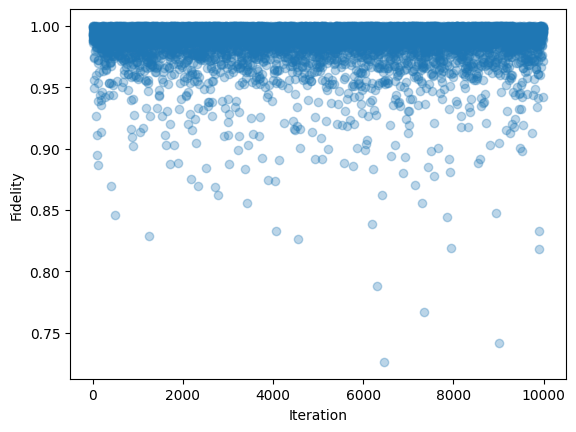

In [7]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [8]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

1 0.9857382297995831
8 0.9874488922888052
14 0.9884992552748502
16 0.9880664612668504
18 0.9893226087269701
22 0.9886413725191456
24 0.9736500682833596
29 0.9490533327464307
33 0.9888784690838885
35 0.9897897120773621
36 0.9557530697588462
43 0.9743684331575294
57 0.9799138617012907
63 0.9870538370508198
68 0.9600363209964221
72 0.92641872331692
75 0.9830020883107503
77 0.9814732092437793
83 0.9894899254470113
94 0.9828193121783277
95 0.9112711772642397
100 0.8951429567722565
101 0.9889445048455935
103 0.9862711866843501
105 0.9891327557634602
109 0.981940607019319
111 0.8867973833789414
112 0.9843407204487574
115 0.9724775497638286
117 0.969466563234948
118 0.9390046979620419
119 0.9531398145481393
123 0.9886665209122146
126 0.9719916757356294
130 0.9877915676193691
133 0.9817882991121106
136 0.989130344009345
137 0.9885724138289967
138 0.9626059910329233
149 0.9862474032454172
153 0.9879430877153552
156 0.9888927985968725
157 0.9434883504638891
161 0.9852069886959075
163 0.9848632393

In [9]:
print(low_fidelities)
print(low_fidelities['theta'])

{'theta': [1.6724742506392356, 1.2550432569554515, 1.8881158592554446, 0.4002257903645167, 2.5228662905749117, 2.2225619539895796, 1.339703658860534, 1.967305545440056, 1.068031807962625, 1.0932744552858884, 1.881713999147485, 1.9772450406229332, 1.94997335688151, 0.7277524347900747, 1.9778146749394194, 3.130272162038654, 1.0945276708556777, 1.8095720492177376, 1.0708423884669467, 1.4434377569101997, 2.7905611415758296, 2.8002482346451845, 2.4877509767748998, 0.77598976365652, 1.0286572590709926, 0.8332456751258431, 3.1216806109146975, 1.3802096846038248, 1.8798399571578637, 2.011225973414484, 2.807095804520533, 1.330830540576504, 2.735028738002043, 2.1135545470843575, 1.9011602369920515, 1.9437936713116926, 2.9326924546340036, 1.8435921648766986, 2.7184859102847505, 2.046631136699849, 1.8871863043594956, 2.877677700330979, 2.6486958012406414, 1.580631039928655, 1.087302512814669, 1.93413187267595, 1.6739363241902507, 1.7007447887119644, 1.6780336291854712, 2.7064212428669703, 1.451277

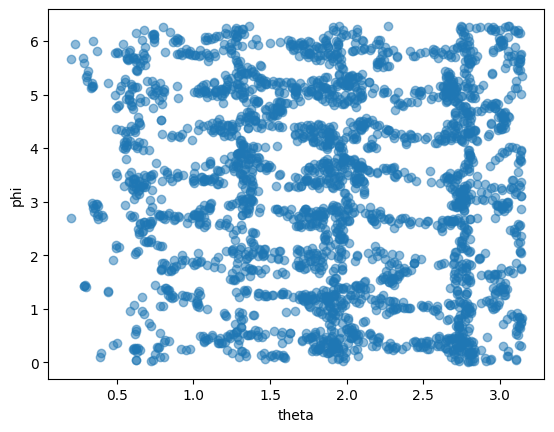

In [10]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

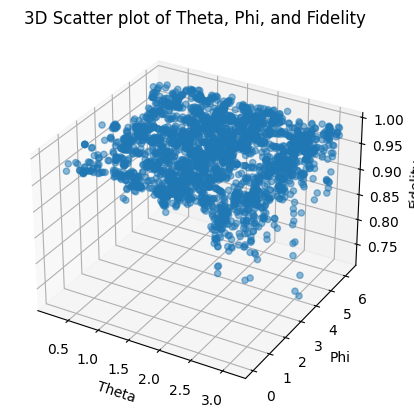

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3차원 그래프 생성
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(low_fidelities['theta'], low_fidelities['phi'], low_fidelities['fidelity'], alpha=0.5)
ax.set_xlabel('Theta')
ax.set_ylabel('Phi')
ax.set_zlabel('Fidelity')
plt.title('3D Scatter plot of Theta, Phi, and Fidelity')
plt.show()
